**Read Dataset**

In [80]:
%cd ./content/cassavaleafdata

c:\AIO\AIO_Excercises\Module_6\Convolutional_Neural_Network\content\cassavaleafdata


In [10]:
data_paths = {
    'train': './train',
    'valid': './validation',
    'test': './test'
}

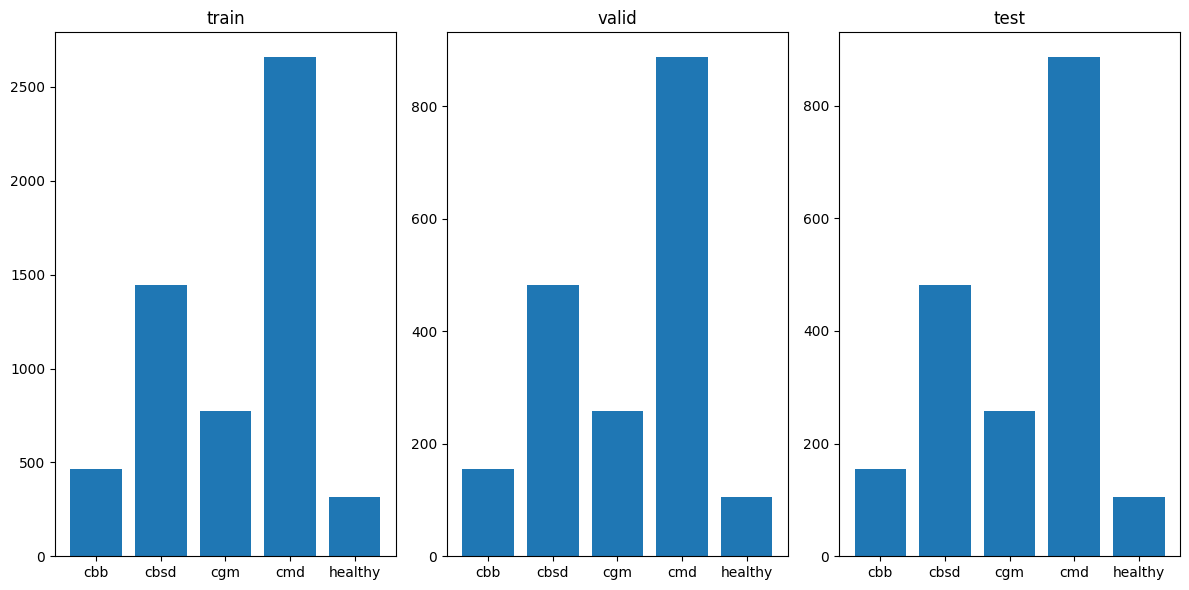

In [11]:
!pip install imutils
import os
import matplotlib.pyplot as plt
from imutils import paths
def show_labels(data_paths):
    fig, ax = plt.subplots(1, len(data_paths), figsize=(12,6))
    for idx, (key, sub_dir) in enumerate(data_paths.items()):
        labels = os.listdir(sub_dir)
        list_data = []
        for label in labels:
            image_files = list(paths.list_images(os.path.join(sub_dir, label)))
            list_data.append(len(image_files))
        ax[idx].bar(labels, list_data)
        ax[idx].set_title(key)
    plt.tight_layout()
    plt.show()

show_labels(data_paths)

In [12]:
labels_dict = {
    "cbb": "Cassava Bacterial Blight (CBB)",
    "cbsd": "Cassava Brown Streak Disease (CBSD)",
    "cgm": "Cassava Green Mottle (CGM)",
    "cmd": "Cassava Mosaic Disease (CMD)",
    "healthy": "Healthy"
}

In [18]:
import os
def plot_images(data_dir, label, num_sample=6):
    data_dir = os.path.join(data_dir, label)
    image_files = list(paths.list_images(data_dir))[:num_sample]
    fig, ax = plt.subplots(2,num_sample//2, figsize=(14,7))
    for i, image_dir in enumerate(image_files):
        img = Image.open(image_dir)
        label = os.path.basename(os.path.dirname(image_dir))
        ax[i//(num_sample//2)][i%(num_sample//2)].imshow(img)
        ax[i//(num_sample//2)][i%(num_sample//2)].set_title(labels_dict[label])
        ax[i//(num_sample//2)][i%(num_sample//2)].axis('off')
    plt.tight_layout()
    plt.show()

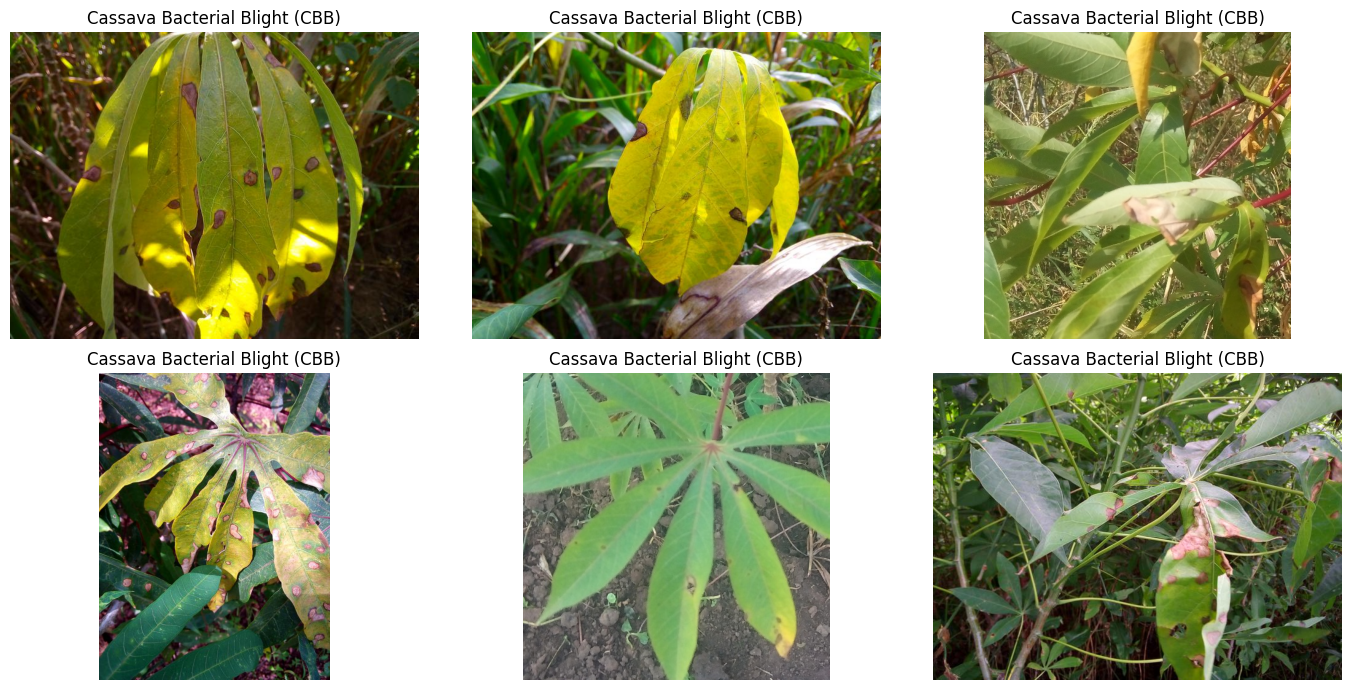

In [19]:
from PIL import Image

plot_images(data_paths['train'], label="cbb")

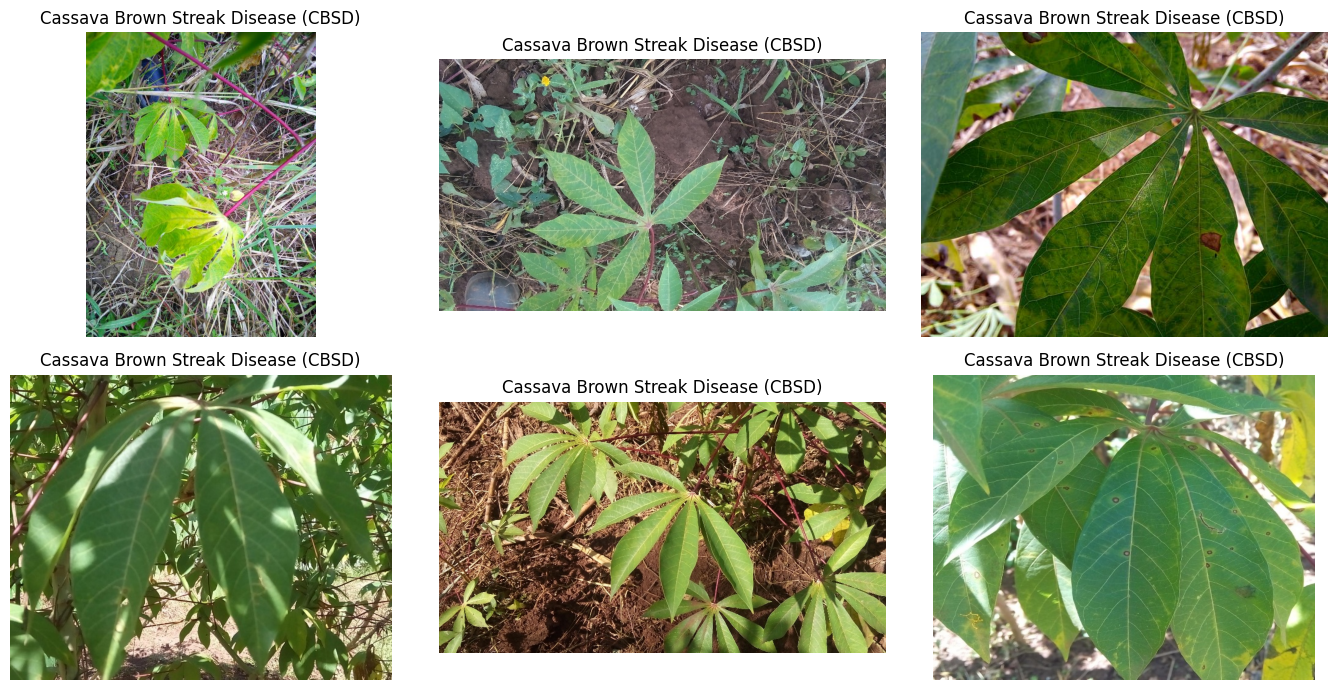

In [20]:
plot_images(data_paths['train'], label="cbsd")

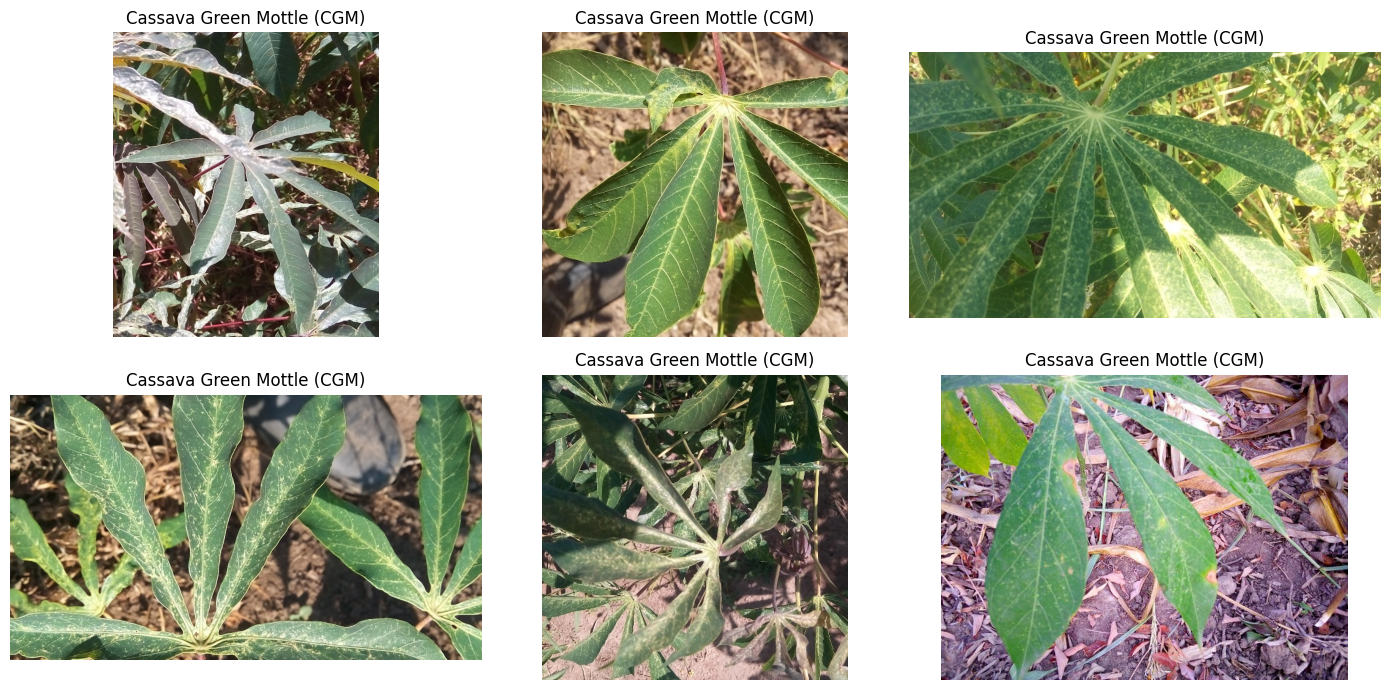

In [21]:
plot_images(data_paths['train'], label="cgm")

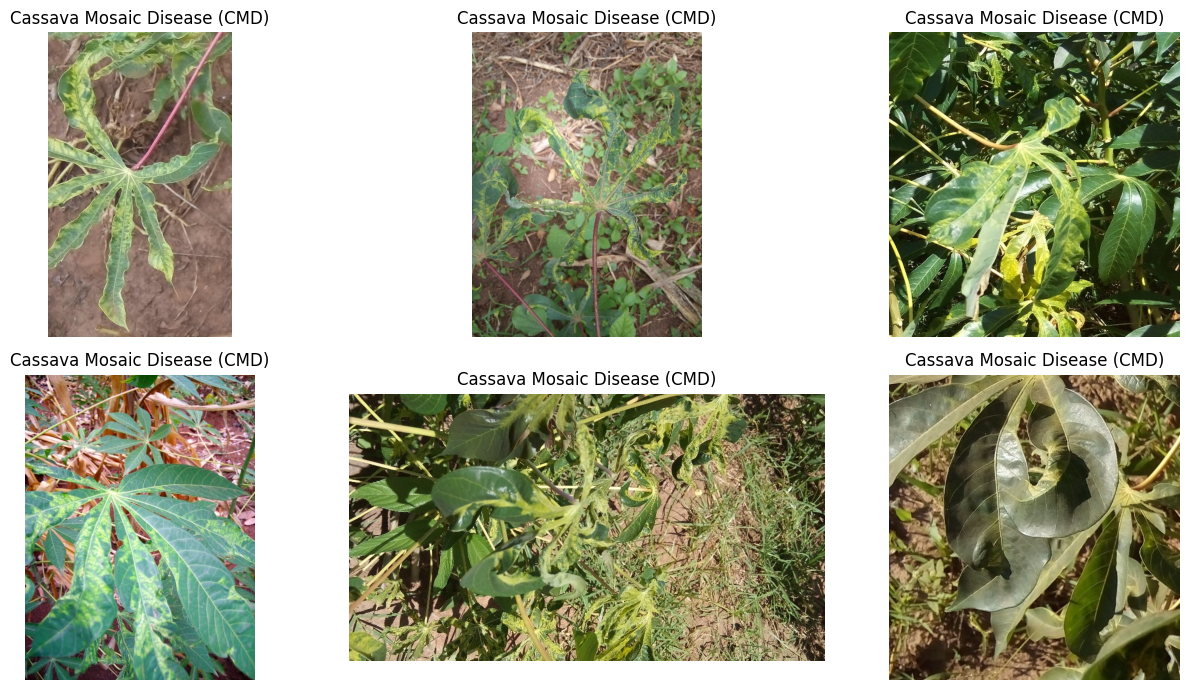

In [22]:
plot_images(data_paths['train'], label="cmd")

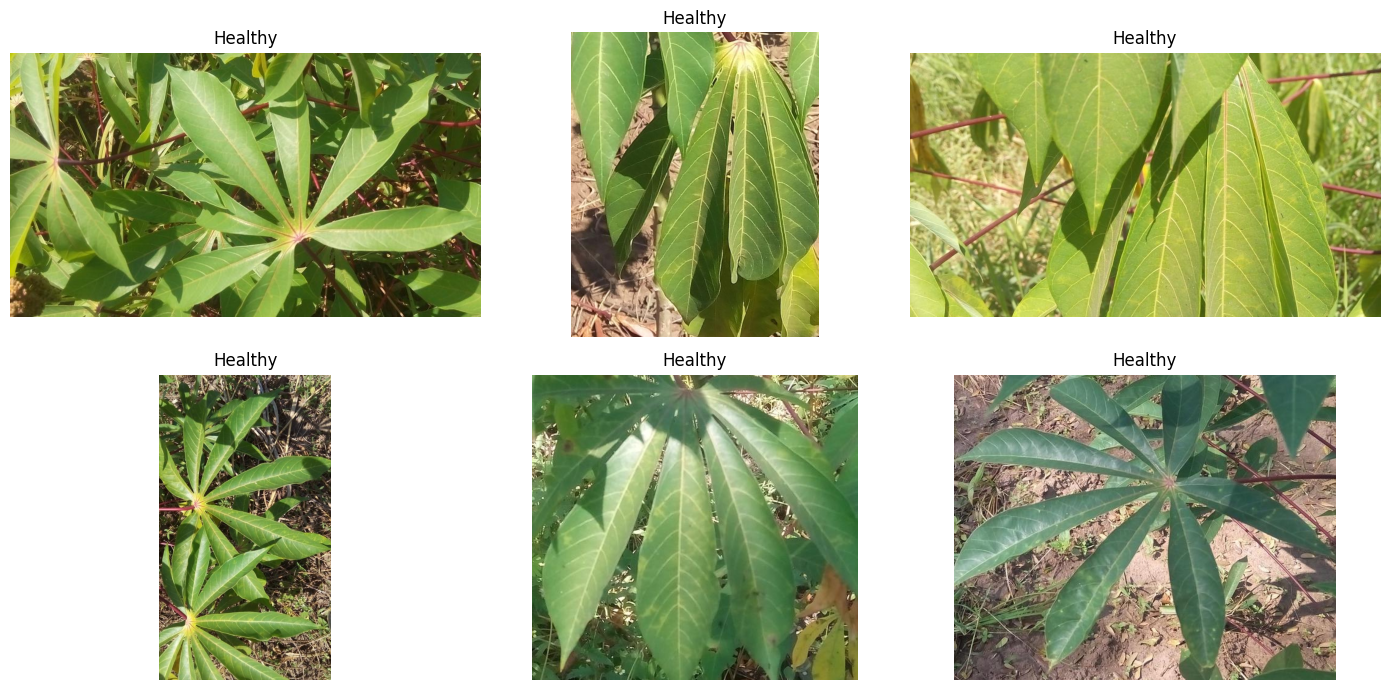

In [23]:
plot_images(data_paths['train'], label="healthy")

#### **Preprocessing**

In [24]:
# load image from path
def loader(path):
    return Image.open(path)

In [28]:
from torchvision import datasets, transforms
img_size = 150

train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(
    root=data_paths['train'],
    loader=loader,
    transform=train_transforms
)
valid_data = datasets.ImageFolder(
    root=data_paths['valid'],
    transform=train_transforms
)
test_data = datasets.ImageFolder(
    root=data_paths['test'],
    transform=train_transforms
)

#### **Dataloader**

In [30]:
from torch.utils import data
BATCH_SIZE = 512

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)
valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

In [31]:
len(train_dataloader)

12

In [32]:
inputs, labels = next(iter(train_dataloader))

In [33]:
inputs.shape, labels.shape

(torch.Size([512, 3, 150, 150]), torch.Size([512]))

#### **Model**

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=6, kernel_size=5, padding='same'
        )
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 35 * 35, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

In [36]:
num_classes = len(train_data.classes)
num_classes

5

In [37]:
lenet_model = LeNetClassifier(num_classes)

In [39]:
!pip install torchsummary
from torchsummary import summary

summary(lenet_model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 150, 150]             456
         AvgPool2d-2            [-1, 6, 75, 75]               0
            Conv2d-3           [-1, 16, 71, 71]           2,416
         AvgPool2d-4           [-1, 16, 35, 35]               0
           Flatten-5                [-1, 19600]               0
            Linear-6                  [-1, 120]       2,352,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                    [-1, 5]             425
Total params: 2,365,581
Trainable params: 2,365,581
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 2.20
Params size (MB): 9.02
Estimated Total Size (MB): 11.48
----------------------------------------------------------------


c:\Users\ACER\miniconda3\Lib\site-packages\torch\cuda\__init__.py:182: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0


In [40]:
inputs.shape

torch.Size([512, 3, 150, 150])

In [42]:
predictions = lenet_model(inputs)
predictions

tensor([[ 0.0103, -0.0553, -0.0295, -0.1014,  0.0540],
        [ 0.0182, -0.0645, -0.0323, -0.0984,  0.0522],
        [ 0.0027, -0.0569, -0.0223, -0.0888,  0.0539],
        ...,
        [ 0.0051, -0.0604, -0.0153, -0.0927,  0.0371],
        [ 0.0068, -0.0573, -0.0323, -0.0872,  0.0547],
        [ 0.0052, -0.0514, -0.0255, -0.0917,  0.0524]],
       grad_fn=<AddmmBackward0>)

#### **Loss & Optimizer**

In [61]:
import torch.optim as optim
optimizer = optim.Adam(lenet_model.parameters())

In [62]:
criterion = nn.CrossEntropyLoss()

In [63]:
loss = criterion(predictions, labels)
loss

tensor(1.6437, grad_fn=<NllLossBackward0>)

In [64]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
lenet_model.to(device)

LeNetClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=19600, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=5, bias=True)
)

#### **Trainer**

In [66]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=15):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [67]:
train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device)

In [68]:
train_acc, train_loss

(0.33875530410183874, 1.787544846534729)

In [69]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [70]:
eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)

In [71]:
eval_acc, eval_loss

(0.4695606140815246, 1.3630571961402893)

#### **Training**

In [81]:
num_classes = len(train_data.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
learning_rate = 2e-4
optimizer = optim.Adam(lenet_model.parameters(), learning_rate)

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch, log_interval=10)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict(), save_model + '/lenet_model_Cassava_Leaf_Disease.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    lenet_model.load_state_dict(torch.load(save_model + '/lenet_model_Cassava_Leaf_Disease.pt', weights_only=True))
    lenet_model.eval()

| epoch   1 |    10/   12 batches | accuracy    0.431
-----------------------------------------------------------
| End of epoch   1 | Time: 48.01s | Train Accuracy    0.500 | Train Loss    1.420 | Valid Accuracy    0.470 | Valid Loss    1.368 
-----------------------------------------------------------
| epoch   2 |    10/   12 batches | accuracy    0.470
-----------------------------------------------------------
| End of epoch   2 | Time: 48.79s | Train Accuracy    0.500 | Train Loss    1.343 | Valid Accuracy    0.470 | Valid Loss    1.345 
-----------------------------------------------------------
| epoch   3 |    10/   12 batches | accuracy    0.471
-----------------------------------------------------------
| End of epoch   3 | Time: 48.57s | Train Accuracy    0.417 | Train Loss    1.345 | Valid Accuracy    0.471 | Valid Loss    1.330 
-----------------------------------------------------------
| epoch   4 |    10/   12 batches | accuracy    0.471
-------------------------------

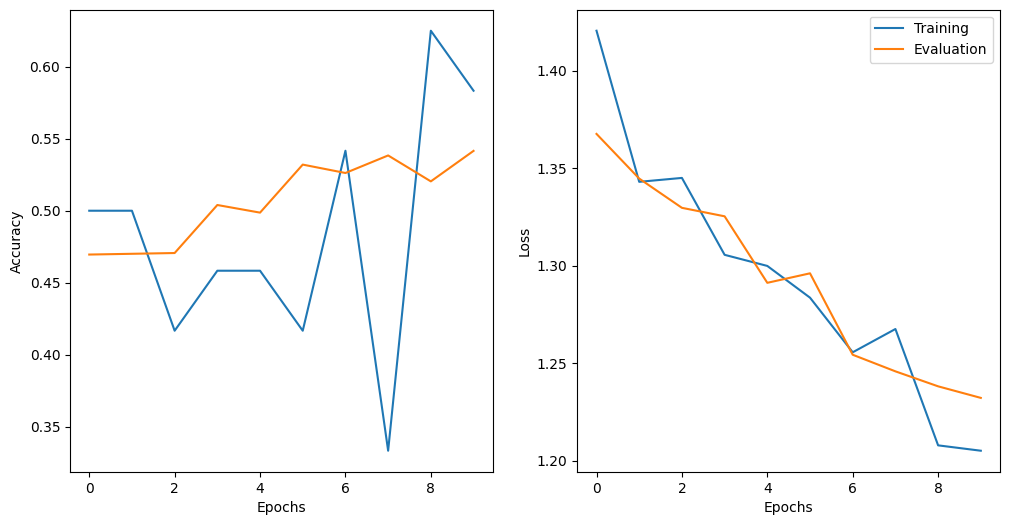

In [82]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

#### **Evaluation & Prediction**

In [83]:
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader, device)
test_acc, test_loss

(0.5368700265251989, 1.2204310297966003)

In [84]:
def load_model(model_path, num_classes=5):
    lenet_model = LeNetClassifier(num_classes)
    lenet_model.load_state_dict(torch.load(model_path, weights_only=True))
    lenet_model.eval()
    return lenet_model

def inference(img_path, model):
    image = Image.open(img_path)
    img_size = 150

    img_transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ])
    img_new = img_transform(image)
    img_new = torch.unsqueeze(img_new, 0)
    with torch.no_grad():
        predictions = model(img_new)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return p_max.item(), yhat.item()

In [89]:
model = load_model('./model/lenet_model_Cassava_Leaf_Disease.pt')
preds = inference('./test/cbsd/test-cbsd-1.jpg', model)
preds

(0.6456015110015869, 1)

In [90]:
train_data.class_to_idx

{'cbb': 0, 'cbsd': 1, 'cgm': 2, 'cmd': 3, 'healthy': 4}

In [91]:
idx2label = {
  0: 'cbb',
  1: 'cbsd',
  2: 'cgm',
  3: 'cmd',
  4: 'healthy',
}

In [92]:
idx2label[4]

'healthy'